## Data Processing

In [14]:
import csv
import re

letters_data_file = 'zwingli_letters.txt'
output_csv_file = 'letter_connections.csv'
letter_connections = {}
pattern = r"Nr.\s*(\d+[a-z]?)\s*([\w\s\(\).]+?)\s*\ban\s*([\w\s\(\).,]+?)\s*-([\w\s\(\).,?\<\>/-]*)?,\s*([\w\s\(\).IVXLCDM?]+)"

with open(letters_data_file, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            number = match.group(1).strip()
            sender = match.group(2).strip().replace('(', '').replace(')', '').strip()
            receiver = match.group(3).strip().replace('(', '').replace(')', '').strip()
            city = match.group(4).replace('<', '').replace('>', '').replace('(', '').replace(')', '').strip()
            date = match.group(5).replace('(', '').replace(')', '').strip()
            # Note the change to set(sender, receiver) here
            connection = frozenset([sender, receiver])
            if connection in letter_connections:
                letter_connections[connection] += 1
            else:
                letter_connections[connection] = 1

# Write letter connections to a CSV file
with open(output_csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Sender', 'Receiver', 'Count'])
    for connection, count in letter_connections.items():
        sender, receiver = list(connection)
        writer.writerow([sender, receiver, count])

print(f"Data saved to '{output_csv_file}' CSV file.")


Data saved to 'letter_connections.csv' CSV file.


## Create the network graph

In [19]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Use Seaborn styles for more modern looking plots
sns.set_style("white")

mpl.rc('font', family='DejaVu Sans', size=10)

# Read the CSV file
df = pd.read_csv('letter_connections.csv')

# Create an empty graph
G = nx.Graph()

# Add nodes (senders and receivers) with weighted edges based on count
for _, row in df.iterrows():
    sender = row['Sender']
    receiver = row['Receiver']
    count = row['Count']
    if count > 1:
        G.add_edge(sender, receiver, weight=count)

# Create a subgraph centered on Zwingli
center = 'Zwingli'
subgraph = nx.ego_graph(G, center, radius=1)

# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Print degree centrality for each node
for node, centrality in degree_centrality.items():
    if node == 'Zwingli':
        print(f"Degree centrality of {node}: {centrality}")

Number of nodes: 90
Number of edges: 89
Degree centrality of Zwingli: 0.9887640449438202


## Plot the network

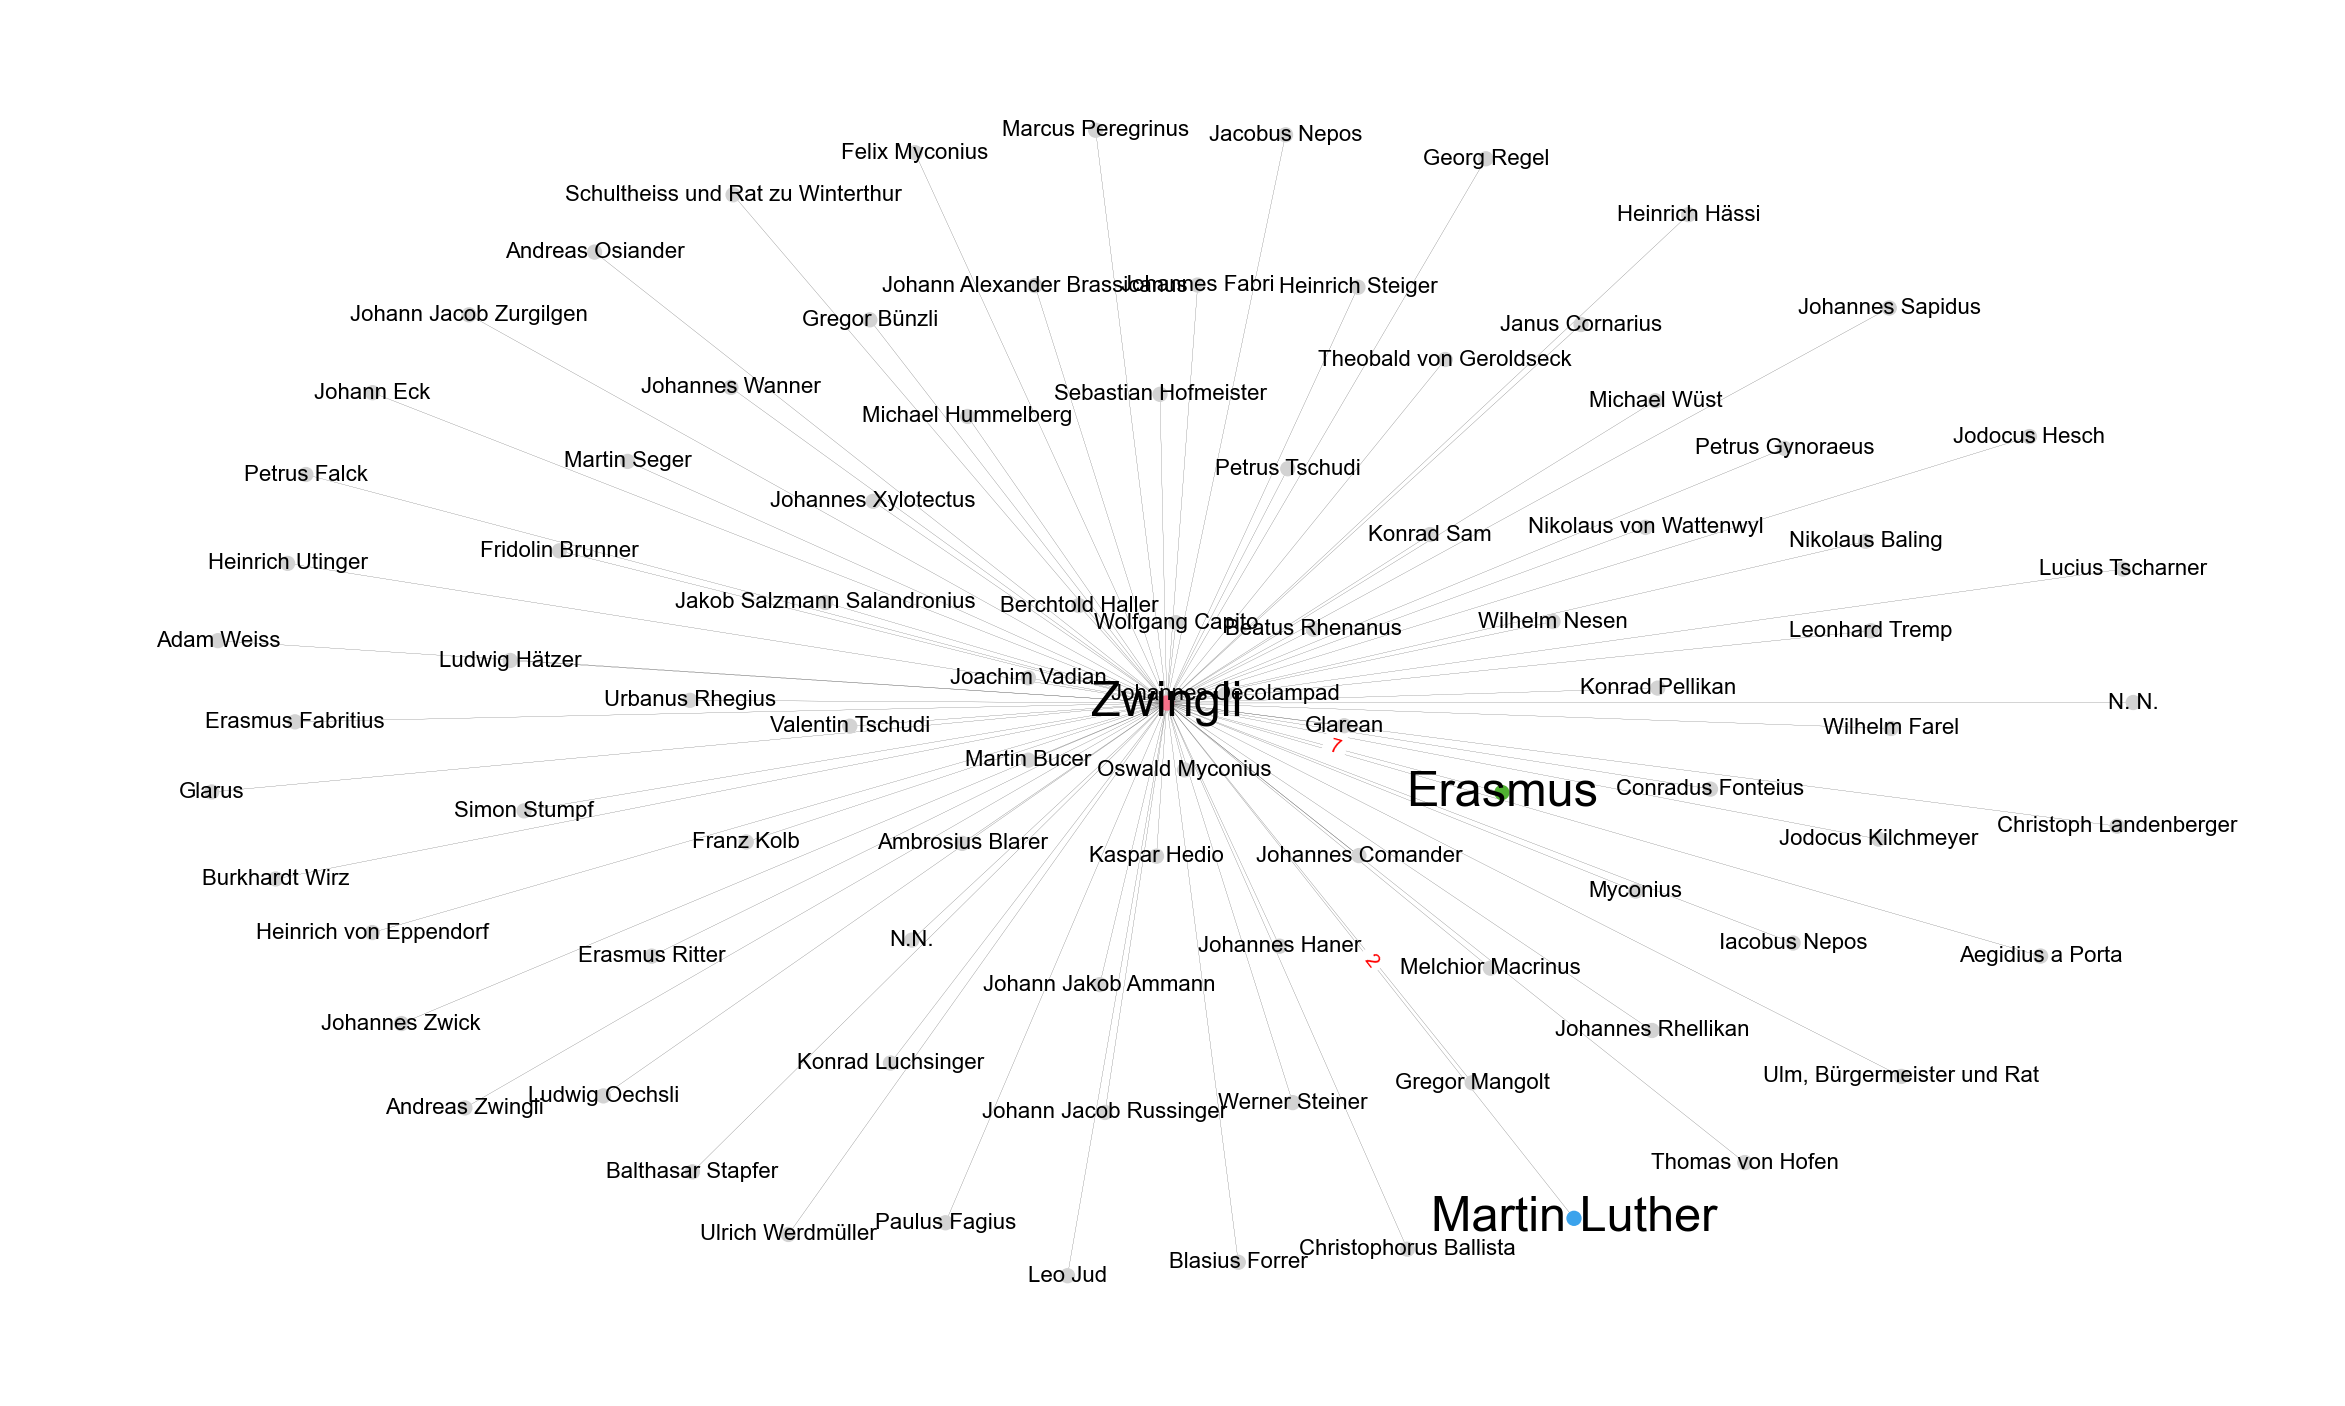

In [16]:
# Set the size of the plot
plt.figure(figsize=(30, 18))

# Set the position of nodes based on spring layout with weight reflecting counts
pos = nx.spring_layout(subgraph, weight='weight', scale=2)
nx.draw_networkx_edges(subgraph, pos, width=0.1)

# Specify nodes for 'Zwingli', 'Erasmus', and 'Martin Luther' with a different color
special_nodes = [node for node in ['Zwingli', 'Erasmus', 'Martin Luther'] if node in subgraph.nodes()]
special_colors = {node: color for node, color in zip(special_nodes, sns.color_palette("husl", len(special_nodes))) if node in subgraph.nodes()}
other_colors = 'lightgray'

# Draw the nodes
nx.draw_networkx_nodes(subgraph, pos, node_color=[special_colors.get(node, other_colors) for node in subgraph.nodes()], node_size=100)

# Draw the edges and labels
nx.draw_networkx_edges(subgraph, pos, width=0.1, alpha=0.2)
nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in special_nodes if node in subgraph.nodes()}, font_size=35)
nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in subgraph.nodes() if node not in special_nodes}, font_size=16)

# Get the edge labels for the edges connecting 'Zwingli', 'Erasmus', and 'Martin Luther'
edge_labels = {(center, node): subgraph.edges[center, node]['weight'] for node in special_nodes if subgraph.has_edge(center, node)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red', font_size=14)

plt.axis('off')

# Show the plot
plt.show()
